In [3]:
import pandas as pd
import numpy as np
from random import randint, uniform
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors

In [4]:
centroids=pd.DataFrame([(1,1.33,2.5),(2,3.33, 4)], columns=['id','x', 'y'])
centroids

,id,x,y
0,1,1.33,2.5
1,2,3.33,4.0


In [5]:
data=pd.DataFrame([(1,1,1.5),
                   (2,1,4.5),
                   (3,2,1.5),
                   (4,2,3.5),
                   (5,3,2.5),
                   (6,5,6)], columns=['id','x', 'y'])
data

,id,x,y
0,1,1,1.5
1,2,1,4.5
2,3,2,1.5
3,4,2,3.5
4,5,3,2.5
5,6,5,6.0


In [64]:
class Kmeans:
    def __init__(self, k, data):
        self.k=k
        self.initial_data = data.copy()
        
        # initialize k centroids with mock values
        self.initial_centroids=pd.DataFrame(
            np.full((self.k,self.initial_data.shape[1]),-1.0),
            columns=self.initial_data.columns.values)
        self.initial_centroids['id']=np.arange(1,self.k+1)
        
        # assign points to mock clusters
        self.initial_data['k']=-1
        self.initial_data['distance']=-1
        
        # add suffixes to columns
        self.initial_data.columns += '_d'
        self.initial_centroids.columns += '_c'
        
        
        #create key to allow for join to get cartesian product
        self.initial_data['key']=1
        self.initial_centroids['key']=1
        
        # copy dataframes
        self.data=self.initial_data.copy()
        self.centroids = self.initial_centroids.copy()
        
    
    def assign_centroids(self, dataframe, centroids, i):
        
        # compute euclidan distance for all combinations
        # NOTICE: possible to calculate it with nearest neighbors (skleran.NearestNeighbors), 
        # but we were not sure if we could use it
        
        df_tmp = dataframe.merge(centroids, how='outer')
        df_tmp['distance_d'] = df_tmp.apply(lambda x: np.linalg.norm(
            x[self.data.columns.values.tolist()[1:-3]].values
            -x[self.centroids.columns.values.tolist()[1:-1]].values),axis=1)

        # assign centroid that is closest to the record
        df_tmp=df_tmp.sort_values(['id_d','distance_d']).drop_duplicates(['id_d'],keep='first')
        df_tmp.reset_index(inplace=True)
        df_tmp['k_d']=df_tmp['id_c']
        df_tmp=df_tmp[self.data.columns.values.tolist()].copy()
        return df_tmp
    
    
    def calculate_centroids(self):
        # calculate position of centroids
        cols=self.centroids.columns
        self.centroids=self.data.drop(['id_d','distance_d'], axis=1).groupby(['k_d']).agg(['mean'])
        self.centroids.reset_index(inplace=True) 
        self.centroids.columns=cols
    
    
    def initialize_clusters(self, method='forgy'):
        '''
        Names of methods taken from article:
        A comparative study of efficient initialization methods for the k-meansclustering algorithm
        
        METHODS:
        
        macqueen - randomly selected points. k distinct cases of the data are randomly selected 
        to be the initial centres. The second method chooses the centers randomly from the data points. 
        The rationale behind this method is that random selection is likely to pick points from dense 
        regions,i.e. points that are good candidates to be centers. 
        
        forgy- assigns each point to one of theKclusters uniformly at random. 
        The centers are then given by the centroids of these initial clusters.
        
        kmpp - random farthest points, or k-means++. 
        The first centre is selected as a random case from the dataset. 
        The 2nd centre is selected also randomly, but the probability of 
        selection of a case is proportional to the distance (square euclidean) of it to that 
        (1st) centre. The 3rd centre is selected also randomly with the probability of selection 
        proportional to the distance of a case to the nearest of those two centres, - and so on. 
        (Arthur, D., Vassilvitskii, S.. K-means++: the advantages of careful seeding. 
        //Proceedings of the 18th annual ACM-SIAM symposium on Discrete algorithms. 2007., 1027–1035.)
        
        robin - The ROBIN approach to seed selection is essentially tied to the concept of avoiding 
        outliers as seeds. For this ROBIN first computes the degree to which a point is an outlier, 
        which in turn must consider the local density of the neighboring points. Outliers are those 
        points whose density is very different compared to neighbor densities. In essence the local 
        outlier measure automatically takes into account variable density regions and variable size 
        clusters. The key aim here is to avoid the computation of outlier measure for each point in 
        the dataset, which would yield a worst case method, but rather the challenge is in keeping 
        the complexity very close to linear in n.
        
        '''
        #reset data and centroids
        self.data=self.initial_data.copy()
        self.centroids=self.initial_centroids.copy()
        
        if method=='macqueen':
            self.data.sample(n=self.k)
            for i in range(0, self.k):
                for col in self.centroids.columns.to_list()[1:-1]:
                    self.centroids.at[i, col]=self.data.at[i, col[:-1]+'d']
                
        
        if method == 'forgy':
            while any(init_k not in self.data['k_d'].values for init_k in range(1,self.k+1)): 
                self.data['k_d']=self.data['k_d'].apply(lambda x: randint(1,self.k))
                
            #calculate initial centroids       
            self.calculate_centroids()
                
        if method == "kmpp":
            tmp_data = self.data.copy()
            for i in range(0,self.k):
                if i == 0:
                    # Take one center c1, chosen uniformly at random from X .
                    initial=randint(0,self.k)
                    for col in self.centroids.columns.values.tolist()[1:-1]:
                        self.centroids.at[i,col] = tmp_data.at[initial,col[:-1]+'d']      
                            
                else:
                    # Take a new center ci choosing x ∈ X with probability D(x) / sum x∈X D(x)
                    tmp_data=self.assign_centroids(tmp_data, self.centroids.iloc[:i+1,:], i)
                    
                    #calculate square distance
                    tmp_data['distance_d']=tmp_data['distance_d']**2
                    sum_of_distance=tmp_data['distance_d'].sum()
                    tmp_data['probability']=tmp_data['distance_d']/sum_of_distance
                    
                    #choose  new centroid with probability D(x) / sum  x∈X D(x)
                    select_random=uniform(0,1)
                    cumulant=0
                    for j in range(tmp_data.shape[0]):
                        cumulant = cumulant + tmp_data.at[j, 'probability']
                        if select_random <= cumulant:
                            for col in self.centroids.columns.values.tolist()[1:-1]:
                                self.centroids.at[i, col] = tmp_data.at[j,col[:-1]+'d']
                            break
            #assign points to nearest centroids created with seeding
            #self.data=self.assign_centroids(self.data, self.centroids, i)
            
        if method=='robin':
            tmp_data=self.data.copy()
            clf = LocalOutlierFactor(n_neighbors=3, novelty=True)
            
            for i in range(0,self.k):
                
                if i==0:
                    r=self.data.sample(n=1)
                    tmp_data['robin_dist']= tmp_data.apply(lambda x: np.linalg.norm(
                        x[self.data.columns.values.tolist()[1:-3]].values
                        -r[self.data.columns.values.tolist()[1:-3]].values),axis=1)
                    sorted_tmp_data=tmp_data.sort_values('robin_dist', ascending=False)
                    sorted_tmp_data.drop(columns=['k_d','distance_d','key','robin_dist'], inplace=True)
                    sorted_tmp_data.reset_index(drop=True,inplace=True)
                    
                else:
                    tmp_data=self.assign_centroids(tmp_data, self.centroids.iloc[:i+1,:], i)
                    sorted_tmp_data=tmp_data.sort_values('distance_d', ascending=False)
                    sorted_tmp_data.drop(columns=['k_d','distance_d','key'], inplace=True)
                    sorted_tmp_data.reset_index(drop=True,inplace=True)
                    
                '''
                The critical moment - is this optimal implementation?
                '''    
                for index, row in sorted_tmp_data.iloc[:,1:].iterrows():
                    row=pd.DataFrame(row).T.values
                    clf.fit(sorted_tmp_data.iloc[:,1:].drop(index=index))
                    LOF=clf.predict(row)
                    if LOF[0]==1:
                        for col in self.centroids.columns.values.tolist()[1:-1]:
                            self.centroids.at[i,col] = sorted_tmp_data.at[index,col[:-1]+'d']
                        break
                #assign points to nearest centroids created with seeding
                #self.data=self.assign_centroids(self.data, self.centroids, i)  
                               
    def plot_clusters(self, dataframe, centroids, i):

        #select subset of dataframe with features
        X = dataframe.copy().drop(columns=['id_d','k_d','distance_d','key'])
        y = dataframe['k_d'].copy().values
        
        X_c = centroids.copy().drop(columns=['id_c']).values
        y_c = centroids['id_c'].copy().values
        
        if X.shape[1] == 2:
            method = 'Plot'
            X_reduced_pca = X.values
        else:
            method = 'PCA'
            # calculate PCA Implementation of dim reducition
            X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)

        #plotting
        f, (ax1) = plt.subplots(1, 1, figsize=(6,6))
        f.suptitle('Iteration ' + str(i), fontsize=14)

        # scatter plot
        ax1.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=y, cmap='rainbow', linewidths=4)
        ax1.scatter(X_c[:,0], X_c[:,1], c=y_c, marker='x', s=150, cmap='rainbow', linewidths=10)
        ax1.set_title(method, fontsize=14)
        ax1.grid(True)

        plt.show()
        
    
    def Lloyd(self):
        converged=False
        i=0
        while not converged:
            
            self.plot_clusters(self.data, self.centroids, i)
            
            i+=1
            #cluster assignments before iteration
            clusters_before = self.data['k_d'].values
            
            #cluster assignments after iteration
            self.data=self.assign_centroids(self.data, self.centroids, i)
            clusters_after = self.data['k_d'].values
            
            #check if algorithm converged
            if all(c_before == c_after for c_before, c_after in zip(clusters_before,clusters_after)):
                converged = True
            
            # update centroids
            self.calculate_centroids()
            
            #checking if a cluster disapeared in the process (erronous behaviour)
            if len(self.data.k_d.unique()) != self.k:
                print('Cluster disapeared, break. Temporary solution.')
                raise Exception
    
    def McQuin(self):
        converged=False
        i=0
        while not converged:
            self.plot_clusters(self.data, self.centroids, i)
            
            i+=1            
            #cluster assignments before iteration
            clusters_before = self.data['k_d'].values
            
            for index,row in self.data.iterrows():
            
                # turn row of dataframe with updated point into a dataframe
                row = pd.DataFrame(row).T

                # assign centroid to updated point
                self.data.iloc[index,:]=self.assign_centroids(row, self.centroids, i).values[0]
                
                # update centroids
                self.calculate_centroids()
        
            #cluster assignments after iteration
            clusters_after = self.data['k_d'].values
            
            #check if algorithm converged
            if all(c_before == c_after for c_before, c_after in zip(clusters_before,clusters_after)):
                converged = True
                
            #checking if a cluster disapeared in the process (erronous behaviour)
            if len(self.data.k_d.unique()) != self.k:
                print('Cluster disapeared, break. This is a temporary solution.')
                raise Exception
    

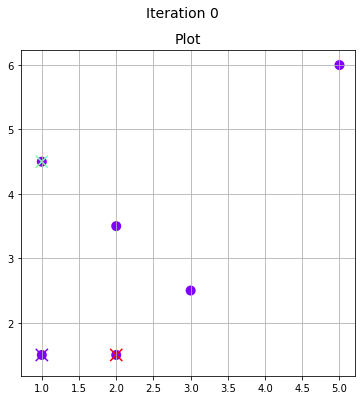

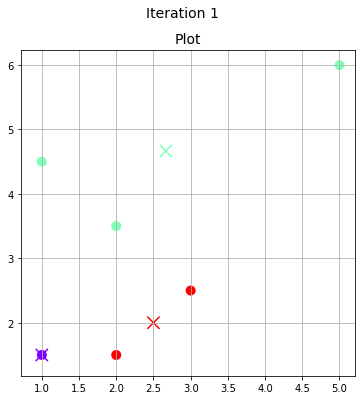

In [65]:
ex4 = Kmeans(3,data)
ex4.initialize_clusters(method='macqueen')
ex4.Lloyd()

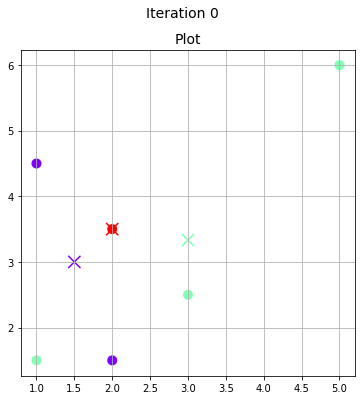

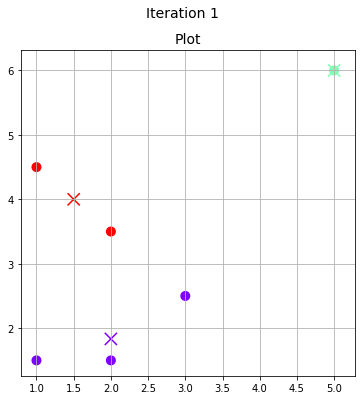

In [66]:
ex4 = Kmeans(3,data)
ex4.initialize_clusters()
ex4.McQuin()